<a href="https://colab.research.google.com/github/JeehwanLim/202103-adv_ml/blob/main/Adv_ML_Fin_Prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기말 텀 프로젝트 3조
> Diamond 가격 예측

## 1. 라이브러리 Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from sklearn import svm, tree, linear_model, ensemble
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

## 2. 데이터 가져오기

In [2]:
!git clone https://github.com/JeehwanLim/202103-adv_ml.git

Cloning into '202103-adv_ml'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


### Context

This classic dataset contains the prices and other attributes of almost 54,000 diamonds. It's a great dataset for beginners learning to work with data analysis and visualization.


### Content

<b> price </b> price in US dollars (\$326--\$18,823)

<b> carat </b> weight of the diamond (0.2--5.01)

<b> cut </b> quality of the cut (Fair, Good, Very Good, Premium, Ideal)

<b> color </b> diamond colour, from J (worst) to D (best)

<b> clarity </b> a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

<b> x </b> length in mm (0--10.74)

<b> y </b> width in mm (0--58.9)

<b> z </b> depth in mm (0--31.8)

<b> depth </b> total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

<b> table </b> width of top of diamond relative to widest point (43--95)

In [3]:
df = pd.read_csv('202103-adv_ml/diamonds.csv', sep=',')
df.shape

(53940, 11)

## 3. 탐색적 자료 분석

In [4]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [6]:
df.describe()

,Unnamed: 0,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,26970.500000,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,15571.281097,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,13485.750000,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,26970.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,40455.250000,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,53940.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [7]:
idx_list = df[(df["x"]==0) | (df["y"]==0) | (df["z"]==0)].index
data = df.drop(idx_list)
print(data.shape)

(53920, 11)


* x,y,z 칼럼에 0 값이 존재하는 레코드들은 제거함

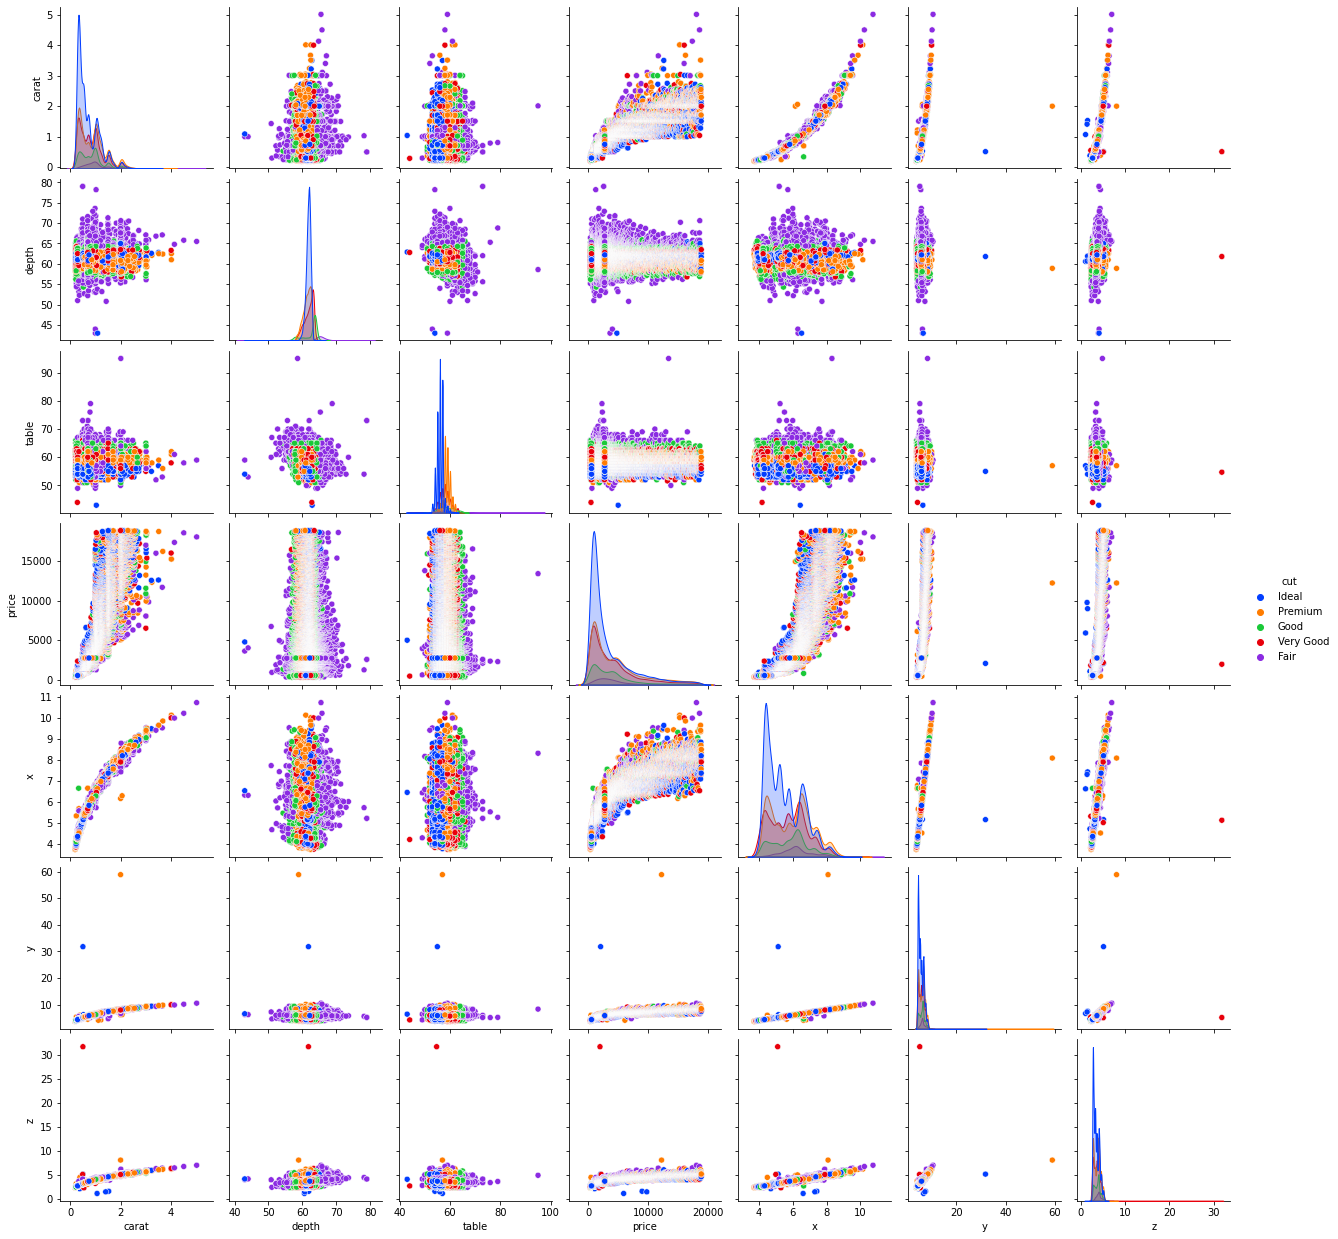

In [ ]:
# 이 셀은 실행하지 말것. 시간 오래 걸림 
# sns.pairplot(data.iloc[:,1:], 
#             diag_kind='kde',
#             hue="cut", 
#             palette='bright') # pastel, bright, deep, muted, colorblind, dark
# plt.show()

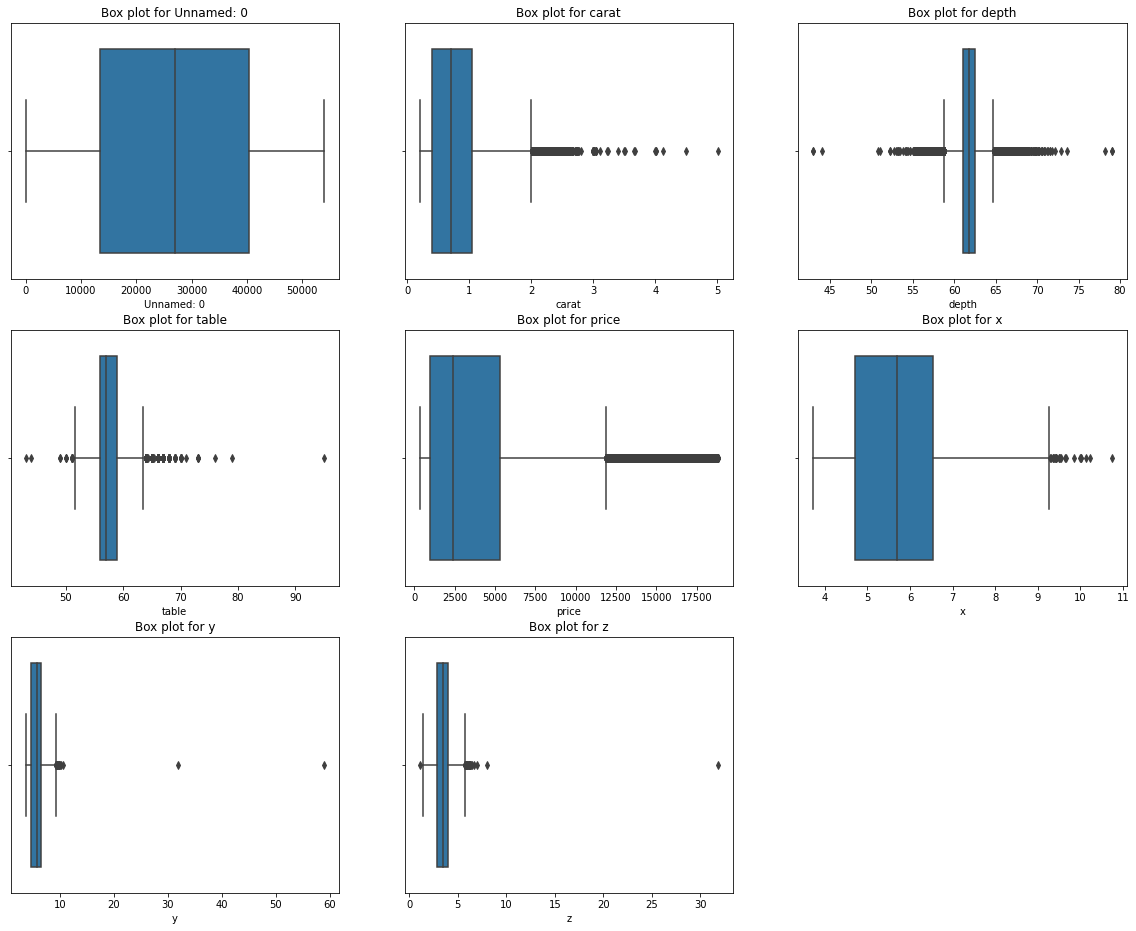

In [8]:
plt.figure(figsize=(20,16))
j=0

num_cols = data.select_dtypes(exclude='object').columns.to_list()

for i in num_cols:
    ax=plt.subplot(331+j)
    ax=sns.boxplot(data=data, x=i)
    ax.set_title("Box plot for {}".format(i))
    j=j+1

plt.show()

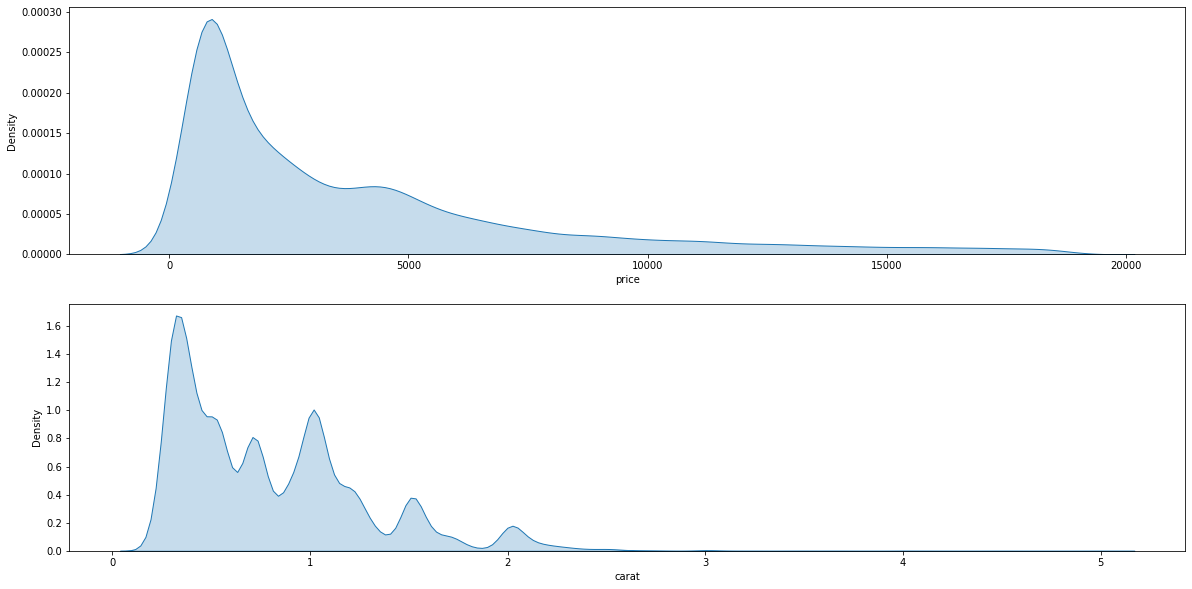

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(211)
sns.kdeplot(data.price, shade=True)

plt.subplot(212)
sns.kdeplot(data.carat, shade=True)

plt.show()

* scatterplot matrix의 가격 행을 보면 Depth, table, y, z 특성에서 outlier가 발견된다. 
* Carat 의 분포를 살펴보면 특정 값(0.3, 0.5, 0.7, 1.0, 1.5, 2.0) 에서 density가 높은 것을 알 수 있다.

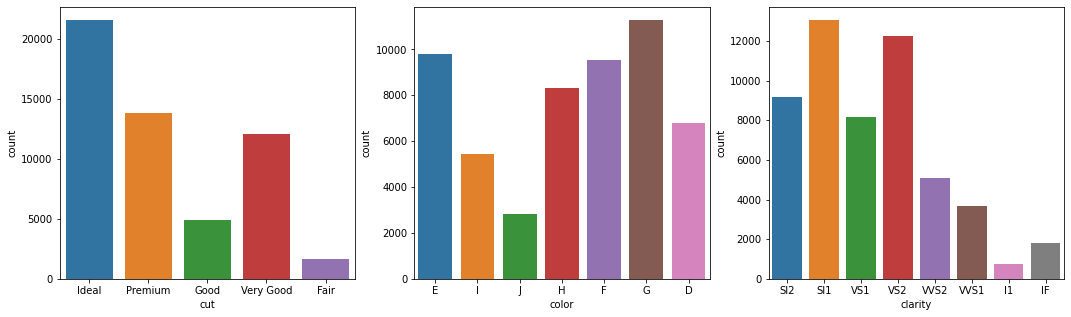

In [10]:
plt.figure(figsize=(18,5))
j=0

cat_cols = data.select_dtypes(include='object').columns.to_list()

for i in cat_cols:
    ax=plt.subplot(131+j)
    ax=sns.countplot(x=i, data=data)
    j=j+1

plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


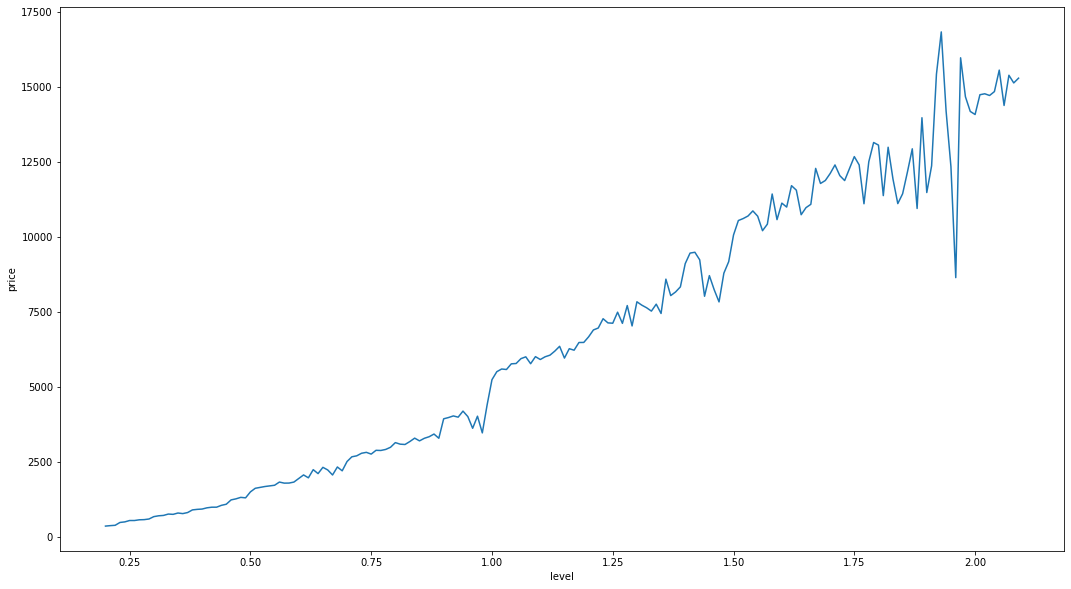

In [11]:
data2 = data[['price','carat']]

bins = list(np.arange(0.2, 2.11, 0.01))
bins_label = [x for x in bins]
bins = list(np.arange(0.195, 2.105, 0.01))
data2["level"] = pd.cut(df["carat"], bins, right=False, labels=bins_label[:-1])
grouped = data2.groupby(['level'], as_index=False).mean()

plt.figure(figsize=(18,10))
sns.lineplot('level', 'price', data=grouped)

* carat과 가격만 놓고 보면 주변보다 캐럿의 density가 높은 곳에서 가격이 급격하게 높아지는 경향을 보인다.

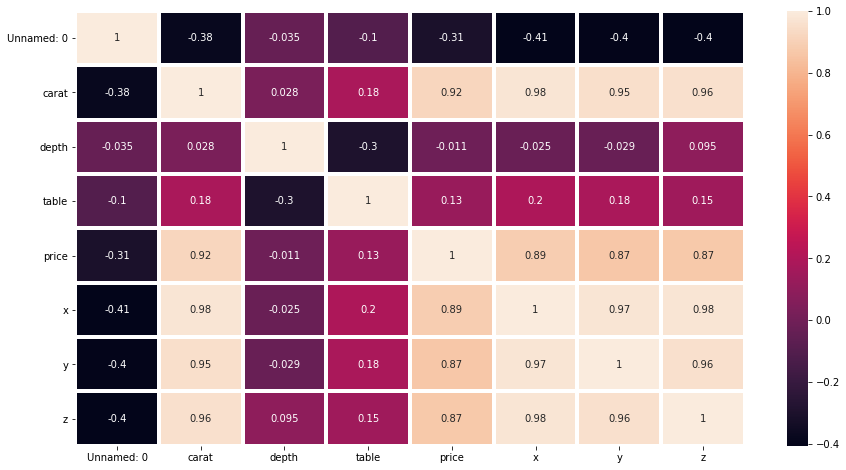

In [12]:
fig=plt.figure(figsize=(15,8))
sns.heatmap(data.corr(), linewidths=3, annot=True)

* 가격은 table이나 depth같은 세부적인 모양에서는 상관계수가 매우 낮게 나왔고, carat이나 x,y,z같은 전체적인 크기에서 강한 양의 상관관계를 보였다.

## 4. 데이터 전처리

In [13]:
data.drop(columns="Unnamed: 0", inplace= True)

* 필요 없는 칼럼(Unnamed: 0) 제거

In [14]:
num_cols = data.select_dtypes(exclude='object').columns.to_list()

for i in num_cols:
    Q1 = data[i].quantile(0.25)
    Q3 = data[i].quantile(0.75)
    IQR = Q3-Q1

    data[i]=np.where(data[i]>(Q3+1.5*IQR),np.NaN,data[i])
    data[i]=np.where(data[i]<(Q1-1.5*IQR),np.NaN,data[i])

In [15]:
data.isna().sum()

carat      1883
cut           0
color         0
clarity       0
depth      2543
table       604
price      3532
x            24
y            22
z            29
dtype: int64

In [16]:
data.dropna(inplace=True)
print(data.shape)
print(data.isna().sum())

(47524, 10)
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


* 아웃라이어 제거 : 1.5IQR 규칙 적용

In [17]:
cat_cols = data.select_dtypes(include='object').columns.to_list()
dataset=pd.get_dummies(data, columns=cat_cols, drop_first=False)
dataset.head()

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326.0,3.95,3.98,2.43,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326.0,3.89,3.84,2.31,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.29,62.4,58.0,334.0,4.20,4.23,2.63,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335.0,4.34,4.35,2.75,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
5,0.24,62.8,57.0,336.0,3.94,3.96,2.48,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [18]:
print(dataset.shape)

(47524, 27)


* 카테고리컬 변수 인코딩 : categorical valiable들이 ordinal하기 때문에 ordinal encoding 또는 one-hot encoding 사용을 고려할 수 있으나 간격이 일정한지 알 수 없기 때문에 one-hot 인코딩 적용

## 5. Train-Test 데이터 나누기

In [19]:
X = dataset.drop(["price"],axis =1)
y = dataset["price"]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [21]:
# 피처 스케일링
sc=StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [22]:
X.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Fair', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1',
       'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

## 6. Modeling

In [23]:
# 선형회귀 = MLE
mle = linear_model.LinearRegression()
mle.fit(X_train, y_train)
y_pred=mle.predict(X_test)

print('R^2: %.4f,  RMSE: %.4f' % (r2_score(y_test, y_pred),np.sqrt(mean_squared_error(y_test,y_pred))))

R^2: 0.9265,  RMSE: 740.2185


([<matplotlib.axis.YTick at 0x7f93c1bcec90>,
 [Text(0, 0, 'carat'),
  Text(0, 0, 'depth'),
  Text(0, 0, 'table'),
  Text(0, 0, 'x'),
  Text(0, 0, 'y'),
  Text(0, 0, 'z'),
  Text(0, 0, 'cut_Fair'),
  Text(0, 0, 'cut_Good'),
  Text(0, 0, 'cut_Ideal'),
  Text(0, 0, 'cut_Premium'),
  Text(0, 0, 'cut_Very Good'),
  Text(0, 0, 'color_D'),
  Text(0, 0, 'color_E'),
  Text(0, 0, 'color_F'),
  Text(0, 0, 'color_G'),
  Text(0, 0, 'color_H'),
  Text(0, 0, 'color_I'),
  Text(0, 0, 'color_J'),
  Text(0, 0, 'clarity_I1'),
  Text(0, 0, 'clarity_IF'),
  Text(0, 0, 'clarity_SI1'),
  Text(0, 0, 'clarity_SI2'),
  Text(0, 0, 'clarity_VS1'),
  Text(0, 0, 'clarity_VS2'),
  Text(0, 0, 'clarity_VVS1'),
  Text(0, 0, 'clarity_VVS2')])

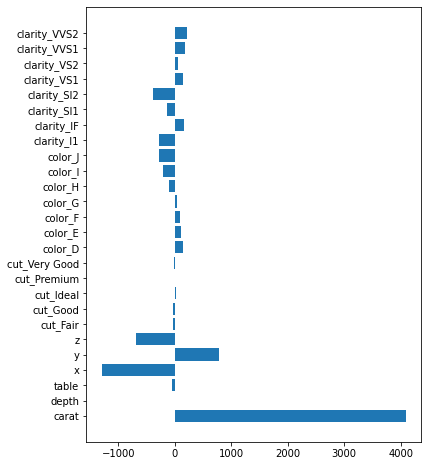

In [24]:
predictors = X.columns

plt.figure(figsize=(6, 8))
plt.barh(y=range(len(mle.coef_)), width=mle.coef_)
plt.yticks(range(len(mle.coef_)), predictors)

* x,y,z의 계수가 모두 양이 아니고 음의 값을 갖는 것은 carat,x,y,z 변수들간의 다중공선성때문으로 보임

In [25]:
# Ridge Regression = MAP
map = linear_model.Ridge(alpha=0.2)
map.fit(X_train, y_train)
y_pred=map.predict(X_test)

print('R^2: %.4f,  RMSE: %.4f' % (r2_score(y_test, y_pred),np.sqrt(mean_squared_error(y_test,y_pred))))

R^2: 0.9265,  RMSE: 740.2251


In [26]:
# SVM
svr = svm.SVR(kernel='linear')
svr.fit(X_train, y_train)
y_pred=svr.predict(X_test)

print('R^2: %.4f,  RMSE: %.4f' % (r2_score(y_test, y_pred),np.sqrt(mean_squared_error(y_test,y_pred))))

R^2: 0.8886,  RMSE: 911.2835


In [27]:
# RandomForest
rf = ensemble.RandomForestRegressor()
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

print('R^2: %.4f,  RMSE: %.4f' % (r2_score(y_test, y_pred),np.sqrt(mean_squared_error(y_test,y_pred))))

R^2: 0.9817,  RMSE: 369.4950


In [28]:
# XGBoost
xgb = XGBRegressor()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)

print('R^2: %.4f,  RMSE: %.4f' % (r2_score(y_test, y_pred),np.sqrt(mean_squared_error(y_test,y_pred))))

[16:45:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
R^2: 0.9692,  RMSE: 479.1104


<BarContainer object of 26 artists>

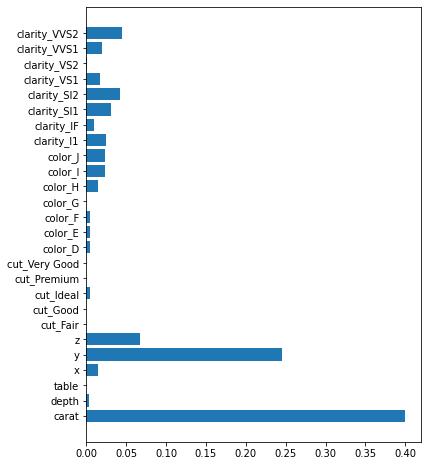

In [29]:
plt.figure(figsize=(6, 8))
plt.barh(X.columns, xgb.feature_importances_)

* carat 특성이 가장 중요함

In [ ]:
# GaussianProcessRegressor

kernel = DotProduct() + WhiteKernel()
regressor = GaussianProcessRegressor(kernel=kernel)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

print('R^2: %.4f,  RMSE: %.4f' % (r2_score(y_test, y_pred),np.sqrt(mean_squared_error(y_test,y_pred))))

* 메모리 풀나서 안돌아감
* tcmalloc: large alloc 8853020672 bytes 